In [1]:
from create_dataset import CreateDataset
from callbacks import LRSchedulerCallback
from train_models import ClassifierTrainer

/Users/aleksejkitajskij/Desktop/DS-Lifehacks/pytorch/train_models.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## multyclass classification

In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [4]:
X = df.drop('species', axis =1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [6]:
num_classes = len(np.unique(y_train))
num_classes

3

In [7]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [8]:
model = Net(X_train.shape[1], 20, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [9]:
scheduler_callback = LRSchedulerCallback(optimizer, 
                                         lr_min=1e-8, 
                                         lr_max=1e-1, 
                                         epochs_total=300, 
                                         growth_rate=0.1)

In [10]:
callbacks = [scheduler_callback]

In [11]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=num_classes,
                            device='cpu',
                            callbacks=callbacks)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=500,
            info_every_iter=20,
            show_val_metrics=False)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/500] Train Loss: 1.1250 Acc: 0.3231 Rec: 0.3231 Prec: 0.2004
Epoch [40/500] Train Loss: 1.0635 Acc: 0.3333 Rec: 0.3333 Prec: 0.1825
Epoch [60/500] Train Loss: 0.9302 Acc: 0.6250 Rec: 0.6250 Prec: 0.5374
Epoch [80/500] Train Loss: 0.7879 Acc: 0.6633 Rec: 0.6633 Prec: 0.5333
Epoch [100/500] Train Loss: 0.7316 Acc: 0.6633 Rec: 0.6633 Prec: 0.5333
Epoch [120/500] Train Loss: 0.6935 Acc: 0.8114 Rec: 0.8114 Prec: 0.9198
Epoch [140/500] Train Loss: 0.6405 Acc: 0.9447 Rec: 0.9447 Prec: 0.9690
Epoch [160/500] Train Loss: 0.6024 Acc: 0.9710 Rec: 0.9710 Prec: 0.9747
Epoch [180/500] Train Loss: 0.5860 Acc: 0.9784 Rec: 0.9784 Prec: 0.9784
Epoch [200/500] Train Loss: 0.5780 Acc: 0.9784 Rec: 0.9784 Prec: 0.9784
Epoch [220/500] Train Loss: 0.5733 Acc: 0.9784 Rec: 0.9784 Prec: 0.9784
Epoch [240/500] Train Loss: 0.5703 Acc: 0.9784 Rec: 0.9784 Prec: 0.9784
Epoch [260/500] Train Loss: 0.5681 Acc: 0.9818 Rec: 0.9818 Prec: 0.9857
Epoch [280/500] Train Loss: 0.5663 Acc: 0.9818 Rec: 0.9818 Prec: 0.9

In [12]:
model = trainer.model
metrics = trainer.metrics

за допомогою побудованого графіку можна проаналізувати яка швидкість навчання є оптимальною. у випадку якщо лінія демонструє певну турбулентність, різкі скачки вниз і вгору це означає що даний діапазон швидкості навчання нестабільний і необхідно взяти значення до цього періоду

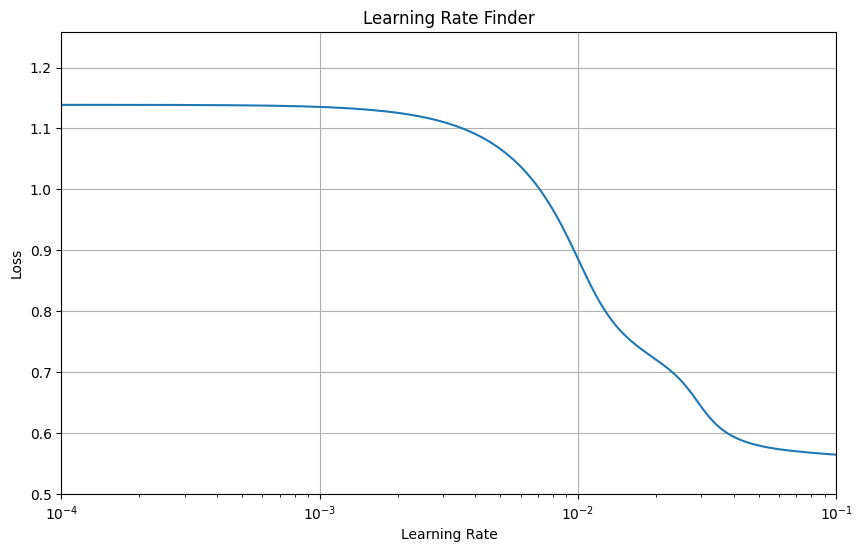

In [13]:
scheduler_callback.plot_lr(x1=1e-4, y1=0.5)